In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
FOLDER_NAME = "annotated"

!unzip "/content/drive/MyDrive/{FOLDER_NAME}.zip" -d "/content"

In [108]:
import numpy as np
import glob
import cv2
from torch.utils.data import Dataset, random_split

file_names = glob.glob(FOLDER_NAME + "/*.jpg")

class ImageDataset(Dataset):
  def __len__(self):
    return len(file_names)

  def __getitem__(self, idx):
    img = cv2.imread(file_names[idx], 0)
    masks = np.load(file_names[idx].replace(".jpg", "_seg.npy"), allow_pickle=True).item()["masks"]
    return img, np.max(masks)

dataset = ImageDataset()

regression_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

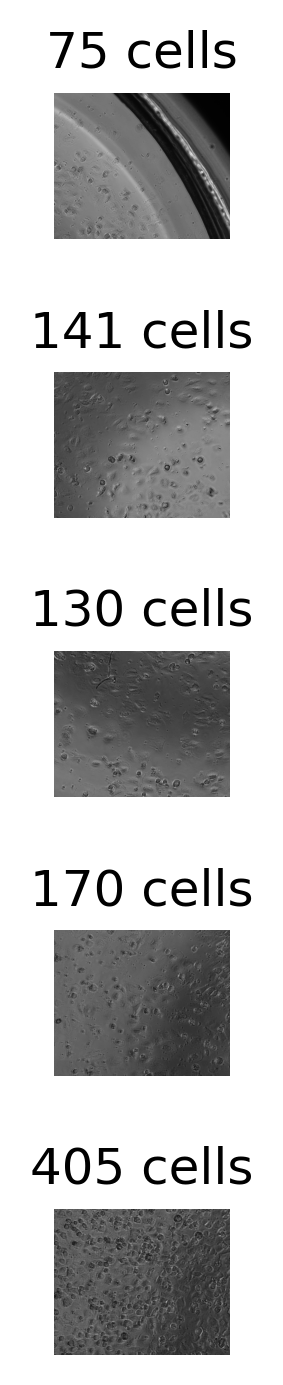

In [117]:
import matplotlib.pyplot as plt

img_num = 5

fig, ax = plt.subplots(nrows = img_num, ncols = 1, dpi=300)
fig.tight_layout()

for i in range(img_num):
  img, cnt = regression_dataset[i]
  ax[i].title.set_text(f"{cnt} cells")
  ax[i].axis("off")
  ax[i].imshow(img, cmap="gray");

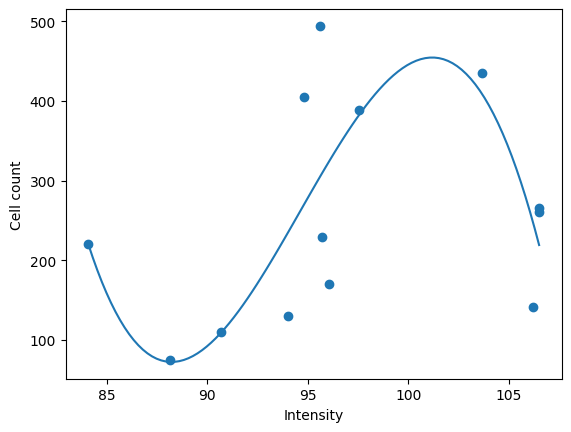

In [115]:
import numpy as np

cell_cnts = np.zeros(len(regression_dataset))
intensities = np.zeros(len(regression_dataset))

for i in range(len(regression_dataset)):
  img, cnt = regression_dataset[i]
  cell_cnts[i] = cnt
  intensities[i] = np.mean(img)

z = np.polyfit(intensities, cell_cnts, deg = 4)
f = np.poly1d(z)

regression_x = np.linspace(np.min(intensities), np.max(intensities), 100)
regression_y = f(regression_x)

plt.xlabel("Intensity")
plt.ylabel("Cell count")
plt.plot(regression_x, regression_y)
plt.scatter(intensities, cell_cnts)
plt.show();

In [116]:
mse = np.zeros(len(test_dataset))

for i in range(len(test_dataset)):
  test_img, test_cnt = test_dataset[i]
  predicted_cnt = f(np.mean(test_img))
  mse[i] = (predicted_cnt - test_cnt) ** 2

print(f"Average deviation (test data): {np.sqrt(np.mean(mse))}")

Average deviation (test data): 131.4911473072921
